In [1]:
import os
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('paper', font_scale=1.2)
import pandas as pd
import scipy.stats
import warnings
from copy import copy

warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [31]:
#Plotting function
#Plotting function
import sys
Scripts_Folder = '/home/sheffieldlab/Desktop/NoReward/Scripts/BayesDecoder/'
sys.path.append(Scripts_Folder)

from PlotDecodingResults import ModelPredictionPlots
from sklearn.model_selection import train_test_split
from sklearn.utils.random import sample_without_replacement
from RunBayesonNorewardData import PrepareBehaviorData as PreBeh
from RunBayesonNorewardData import PreprocessData as PreD
from RunBayesonNorewardData import RunNaiveBayes_ondata as rnb

rnb = rnb()
PreD = PreD()
m = ModelPredictionPlots()

Validation functions
Validation functions


## Prepare datasets

In [3]:
task_dict = {'Task1': '1 Fam Rew',
             'Task2': '2 No Rew',
             'Task3': '3 Fam Rew',
             'Task4': '4 Nov Rew'}

In [4]:
FolderName = '/home/sheffieldlab/Desktop/NoReward/ImagingData/Good_behavior/NR6/'
animalname = os.path.basename(os.path.normpath(FolderName))
frame_lick_stop = 5154
task_numframes = {'Task1': 20000, 
                  'Task2': 20000, 
                  'Task3': 15000, 
                  'Task4': 15000}
#Track Parameters
tracklength = 200 #2m track
trackbins = 5 #5cm bins

In [5]:
SaveResults = os.path.join(FolderName, 'DecoderResults', 'BayesDecoder')
if not os.path.exists(SaveResults):
    os.mkdir(SaveResults)

In [6]:
from Placecells_and_LickCorrelation_EachAnimal import GetData as gd
A = gd(FolderName=FolderName, Task_NumFrames=task_numframes, TaskDict=task_dict, lick_stop=frame_lick_stop)

Number of PlaceCells in Task2 is 129
Number of PlaceCells in Task1 is 133
Number of PlaceCells in Task3 is 123
Number of PlaceCells in Task4 is 119
Number of PlaceCells in Task2a is 129


### Load required Data - load actual running data

#### Control Data

In [7]:
X = A.Fc3data_dict['Task1'].T
Y = A.Parsed_Behavior['running_data'].item()['Task1']

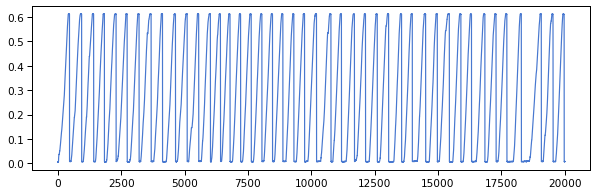

In [8]:
plt.figure(figsize = (10, 3))
plt.plot(Y)

#### No Reward Data

In [9]:
X_Norew = A.Fc3data_dict['Task2'].T
Y_Norew = A.Parsed_Behavior['running_data'].item()['Task2']

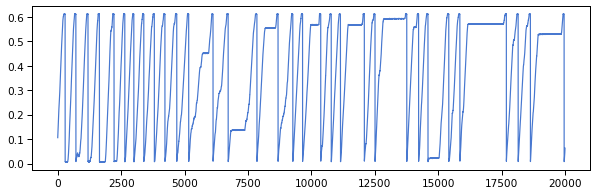

In [10]:
plt.figure(figsize = (10, 3))
plt.plot(Y_Norew)

#### No Reward with good laps

In [11]:
X_Norew_goodlaps = A.Fc3data_dict['Task2'][:, A.Parsed_Behavior['good_running_index'].item()['Task2']].T
Y_Norew_goodlaps = A.Parsed_Behavior['good_running_data'].item()['Task2']

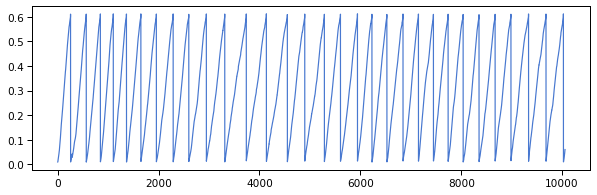

In [12]:
plt.figure(figsize = (10, 3))
plt.plot(Y_Norew_goodlaps)

#### No reward with licks

In [13]:
stoplicklap = A.Parsed_Behavior['lick_stop'].item()
laptime_lick = np.asarray(A.Parsed_Behavior['goodlaps_laptime'].item()['Task2'])[:stoplicklap] 

### Compare velocity of tasks and select laps with comparable speeds

In [14]:
#Comparing two tasks
TaskA = 'Task1'
TaskB = 'Task2'
lapvelocityA, lapvelocityB, common_v_lapsA, common_v_lapsB, worst_lapsB = PreD.get_laps_of_similar_velocity(A, TaskA='Task1', TaskB='Task2', tol=0.4, after_stoplick=1)
correctedlaptime_worstlaps = np.asarray(A.Parsed_Behavior['goodlaps_laptime'].item()['Task2'])[worst_lapsB]

Chosen speeds
Number of chosen laps : Task1 : 18, Task2 : 11
Remainin laps in 11
Task1 [12.23369916 11.23305358 11.07165913  9.26404132  9.97417689 10.16785023
  9.29632021 10.78114913  9.39315688 10.29696578 10.74887024  9.29632021
  9.39315688 10.94254358  9.39315688 10.29696578 12.97611362 10.61975468]
Task2 [12.91155584 13.29890252 10.5551969  11.4912847   9.6191091  11.78179471
 13.10522918  9.941898   10.45836023 11.55584248 13.23434474]
Worst lap speeds Task2
[28.98644287 17.43060039 34.05422853 25.01613944 16.91413815 21.17495158
 28.24402841 38.5087153  57.29502905 13.75080697 41.05874758]


In [15]:
# These laps dont have correct imaging data
common_v_lapsA_corrected = np.array([i for i in common_v_lapsA if i not in [0, 1]])

Data shapes :  (6731, 316) (6731, 1)
[ 2  3  4  5  6  7  9 10 11 12 13 23 26 33 40 41]
[11  7 13  4 26  2  3 40 33 10 23]
New data shapes :  (4133, 316) (4133, 1)


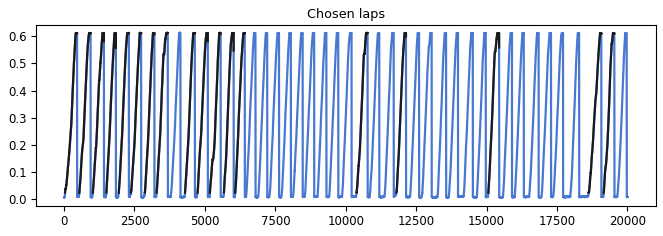

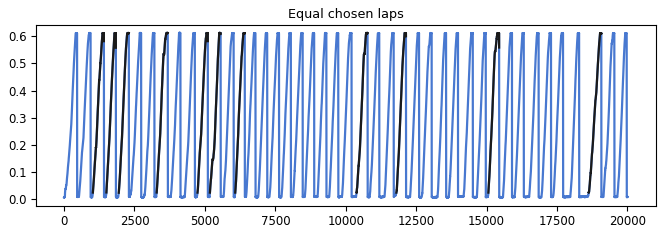

In [16]:
#Control Data
X_v_new, Y_v_new = PreD.compile_data_from_thresholdedlaps(A, Task=TaskA, X_data=X, Y_data=Y, thresholded_laps=common_v_lapsA, E_correction=1, figureflag=1)
X_v_eq, Y_v_eq = PreD.equalise_laps_with_numlaps_innorew(A, X, Y, Tasklabel='Task1', laps_current=common_v_lapsA_corrected, 
                                         numlaps_topick=np.size(common_v_lapsB), E_correction=1)

Data shapes :  (4567, 316) (4567, 1)


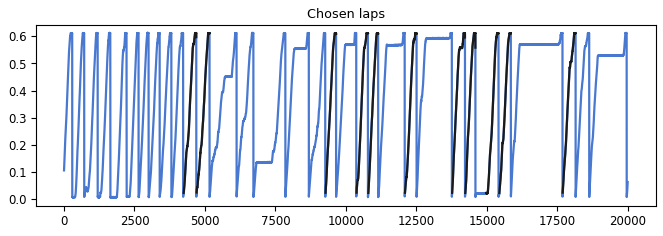

In [17]:
# Reward data with fast laps
X_v_new_norew, Y_v_new_norew = PreD.compile_data_from_thresholdedlaps(A, Task=TaskB, X_data=X_Norew, Y_data=Y_Norew, thresholded_laps=common_v_lapsB, E_correction=2, figureflag=1)

Data shapes :  (3838, 316) (3838, 1)


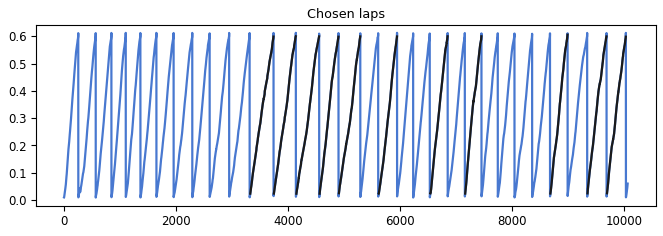

In [18]:
#Reward data with corrected laps
X_new_norew_goodlaps, Y_new_norew_goodlaps = PreD.compile_data_from_thresholdedlaps(A, Task=TaskB, X_data=X_Norew_goodlaps, Y_data=Y_Norew_goodlaps, 
                                              thresholded_laps=worst_lapsB, E_correction=1, 
                                              lapcorrectionflag=1, figureflag=1)

Data shapes :  (2487, 316) (2487, 1)


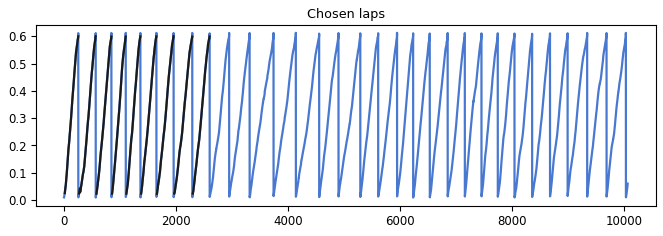

In [19]:
X_v_new_lick, Y_v_new_lick = PreD.compile_data_from_thresholdedlaps(A, Task=TaskB, X_data=X_Norew_goodlaps, Y_data=Y_Norew_goodlaps, thresholded_laps=np.arange(stoplicklap), E_correction=1, lapcorrectionflag=1, figureflag=1)

### Shuffle Data and do k-fold validation

In [26]:
nsplits = 5
niteration = 100

#In order of tasks = 'Control', 'NoReward_Fastlaps', 'NoReward_Slowlaps', 'NoReward_Lick'
figure_flag = 0 #For behavior
E_correction = [1, 2, 1, 1]

In [27]:
mean_R2 = {k: np.zeros(niteration)
           for k in ['Control', 'NoReward_Fastlaps', 'NoReward_Slowlaps', 'NoReward_Lick']}
for i in np.arange(niteration):
    # Shuffle laps and pick up random laps each time to compile
    # Control
    X_v_eq, Y_v_eq = PreD.equalise_laps_with_numlaps_innorew(A, X, Y, Tasklabel='Task1', laps_current=common_v_lapsA_corrected,
                                                             numlaps_topick=np.size(common_v_lapsB), 
                                                             E_correction=E_correction[0], figureflag=0)
    B = PreBeh(BehaviorData=Y_v_eq,
               tracklength=tracklength, trackbins=trackbins, figure_flag=figure_flag)
    y_v_eq_cat = B.position_binary

    # No Reward good laps
    X_v_new_norew, Y_v_new_norew = PreD.compile_data_from_thresholdedlaps(
        A, Task=TaskB, X_data=X_Norew, Y_data=Y_Norew, thresholded_laps=common_v_lapsB,
        E_correction=E_correction[1], randomise=1, figureflag=0)
    B = PreBeh(BehaviorData=Y_v_new_norew, tracklength=tracklength,
               trackbins=trackbins, figure_flag=figure_flag)
    y_v_cat_norew = B.position_binary

    # No Reward worst laps
    X_norew_goodlaps_eq, Y_norew_goodlaps_eq = PreD.equalise_laps_with_numlaps_innorew(A, X_Norew_goodlaps, Y_Norew_goodlaps, Tasklabel='Task2', laps_current=worst_lapsB,
                                                                                       numlaps_topick=np.size(common_v_lapsB), 
                                                                                       E_correction=E_correction[2], lapcorrectionflag=1, figureflag=0)
    B = PreBeh(BehaviorData=Y_norew_goodlaps_eq, tracklength=tracklength,
               trackbins=trackbins, trackstart_index=0, figure_flag=figure_flag)
    y_norew_goodlaps_eq_cat = B.position_binary

    # No Reward before lick stops
    X_v_new_lick, Y_v_new_lick = PreD.compile_data_from_thresholdedlaps(
        A, Task=TaskB, X_data=X_Norew_goodlaps, Y_data=Y_Norew_goodlaps, thresholded_laps=np.arange(
            stoplicklap), randomise=1, E_correction=E_correction[3], lapcorrectionflag=1, figureflag=0)

    B = PreBeh(BehaviorData=Y_v_new_lick, tracklength=tracklength,
               trackbins=trackbins, trackstart_index=0, figure_flag=figure_flag)
    y_v_new_lick_cat = B.position_binary

    # K-Fold validation
    controlcv_dataframe = rnb.k_foldvalidation(
        X_data=X_v_eq, y_cat_data=y_v_eq_cat, split_size=nsplits, figureflag=0)
    mean_R2['Control'][i] = np.mean(controlcv_dataframe['R2'])

    norewardcv_dataframe = rnb.k_foldvalidation(
        X_data=X_v_new_norew, y_cat_data=y_v_cat_norew, split_size=nsplits, figureflag=0)
    mean_R2['NoReward_Fastlaps'][i] = np.mean(norewardcv_dataframe['R2'])

    norewardcv_goodlaps_dataframe = rnb.k_foldvalidation(
        X_data=X_norew_goodlaps_eq, y_cat_data=y_norew_goodlaps_eq_cat, split_size=nsplits, figureflag=0)
    mean_R2['NoReward_Slowlaps'][i] = np.mean(norewardcv_goodlaps_dataframe['R2'])
    
    lickcv_dataframe = rnb.k_foldvalidation(
        X_data=X_v_new_lick, y_cat_data=y_v_new_lick_cat, split_size=nsplits, figureflag=0)
    mean_R2['NoReward_Lick'][i] = np.mean(lickcv_dataframe['R2'])

[ 2  3  4  5  6  7  9 10 11 12 13 23 26 33 40 41]
[ 6 23 11 41  5  7 40  3 26  9 10]
New data shapes :  (4086, 316) (4086, 1)
Data shapes :  (4567, 316) (4567, 1)
[30 13 15 14 29 12 17 22 27 11 20]
[30 13 15 14 29 12 17 22 27 11 20]
New data shapes :  (3838, 316) (3838, 1)
Data shapes :  (2487, 316) (2487, 1)
Performing 5-fold validation
Validation 1
(3268, 316) (3268,) (818, 316) (818,)

Accuracy of test set:: 0.43%
Validation 2
(3269, 316) (3269,) (817, 316) (817,)

Accuracy of test set:: 0.27%
Validation 3
(3269, 316) (3269,) (817, 316) (817,)

Accuracy of test set:: 0.41%
Validation 4
(3269, 316) (3269,) (817, 316) (817,)

Accuracy of test set:: 0.38%
Validation 5
(3269, 316) (3269,) (817, 316) (817,)

Accuracy of test set:: 0.42%
Performing 5-fold validation
Validation 1
(3653, 316) (3653,) (914, 316) (914,)

Accuracy of test set:: 0.30%
Validation 2
(3653, 316) (3653,) (914, 316) (914,)

Accuracy of test set:: 0.19%
Validation 3
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of 

Performing 5-fold validation
Validation 1
(3277, 316) (3277,) (820, 316) (820,)

Accuracy of test set:: 0.38%
Validation 2
(3277, 316) (3277,) (820, 316) (820,)

Accuracy of test set:: 0.31%
Validation 3
(3278, 316) (3278,) (819, 316) (819,)

Accuracy of test set:: 0.45%
Validation 4
(3278, 316) (3278,) (819, 316) (819,)

Accuracy of test set:: 0.35%
Validation 5
(3278, 316) (3278,) (819, 316) (819,)

Accuracy of test set:: 0.30%
Performing 5-fold validation
Validation 1
(3653, 316) (3653,) (914, 316) (914,)

Accuracy of test set:: 0.20%
Validation 2
(3653, 316) (3653,) (914, 316) (914,)

Accuracy of test set:: 0.27%
Validation 3
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.24%
Validation 4
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.27%
Validation 5
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.32%
Performing 5-fold validation
Validation 1
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.18%
Validation 2
(3070, 31


Accuracy of test set:: 0.39%
Validation 4
(3212, 316) (3212,) (803, 316) (803,)

Accuracy of test set:: 0.33%
Validation 5
(3212, 316) (3212,) (803, 316) (803,)

Accuracy of test set:: 0.44%
Performing 5-fold validation
Validation 1
(3653, 316) (3653,) (914, 316) (914,)

Accuracy of test set:: 0.25%
Validation 2
(3653, 316) (3653,) (914, 316) (914,)

Accuracy of test set:: 0.33%
Validation 3
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.26%
Validation 4
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.26%
Validation 5
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.32%
Performing 5-fold validation
Validation 1
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.18%
Validation 2
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.13%
Validation 3
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.25%
Validation 4
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.27%
Validation 5
(3071, 3

Validation 5
(3244, 316) (3244,) (810, 316) (810,)

Accuracy of test set:: 0.26%
Performing 5-fold validation
Validation 1
(3653, 316) (3653,) (914, 316) (914,)

Accuracy of test set:: 0.20%
Validation 2
(3653, 316) (3653,) (914, 316) (914,)

Accuracy of test set:: 0.23%
Validation 3
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.30%
Validation 4
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.31%
Validation 5
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.28%
Performing 5-fold validation
Validation 1
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.18%
Validation 2
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.21%
Validation 3
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.24%
Validation 4
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.25%
Validation 5
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.12%
Performing 5-fold validation
Validation 1
(1989, 31

(3653, 316) (3653,) (914, 316) (914,)

Accuracy of test set:: 0.26%
Validation 2
(3653, 316) (3653,) (914, 316) (914,)

Accuracy of test set:: 0.28%
Validation 3
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.28%
Validation 4
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.22%
Validation 5
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.27%
Performing 5-fold validation
Validation 1
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.26%
Validation 2
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.12%
Validation 3
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.20%
Validation 4
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.23%
Validation 5
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.20%
Performing 5-fold validation
Validation 1
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.43%
Validation 2
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of 

Validation 2
(3653, 316) (3653,) (914, 316) (914,)

Accuracy of test set:: 0.27%
Validation 3
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.27%
Validation 4
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.33%
Validation 5
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.18%
Performing 5-fold validation
Validation 1
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.24%
Validation 2
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.17%
Validation 3
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.21%
Validation 4
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.21%
Validation 5
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.20%
Performing 5-fold validation
Validation 1
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.36%
Validation 2
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.38%
Validation 3
(1990, 316) (1990,) (497, 316) (497,)


Validation 4
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.23%
Validation 5
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.30%
Performing 5-fold validation
Validation 1
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.24%
Validation 2
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.17%
Validation 3
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.08%
Validation 4
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.24%
Validation 5
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.22%
Performing 5-fold validation
Validation 1
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.37%
Validation 2
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.42%
Validation 3
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.30%
Validation 4
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.34%
Validation 5
(1990, 316) (1990,) (497, 316) (497,)


Validation 5
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.33%
Performing 5-fold validation
Validation 1
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.20%
Validation 2
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.23%
Validation 3
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.14%
Validation 4
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.16%
Validation 5
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.23%
Performing 5-fold validation
Validation 1
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.39%
Validation 2
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.32%
Validation 3
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.39%
Validation 4
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.39%
Validation 5
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.35%
[ 2  3  4  5  6  7  9 10 11 12 13 23 26 33 40 41]
[


Accuracy of test set:: 0.24%
Validation 2
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.19%
Validation 3
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.20%
Validation 4
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.20%
Validation 5
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.17%
Performing 5-fold validation
Validation 1
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.39%
Validation 2
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.45%
Validation 3
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.26%
Validation 4
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.45%
Validation 5
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.37%
[ 2  3  4  5  6  7  9 10 11 12 13 23 26 33 40 41]
[10 23 11 41 26 13 33 12  2  4  6]
New data shapes :  (4012, 316) (4012, 1)
Data shapes :  (4567, 316) (4567, 1)
[11 12 29 14 17 22 13 15 20 30 27]
[11 12 29 14 1


Accuracy of test set:: 0.21%
Validation 4
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.14%
Validation 5
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.23%
Performing 5-fold validation
Validation 1
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.44%
Validation 2
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.45%
Validation 3
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.32%
Validation 4
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.40%
Validation 5
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.31%
[ 2  3  4  5  6  7  9 10 11 12 13 23 26 33 40 41]
[ 7  3  5 10 33  6 12 26 11 23 40]
New data shapes :  (4089, 316) (4089, 1)
Data shapes :  (4567, 316) (4567, 1)
[17 11 27 30 20 12 15 14 29 13 22]
[17 11 27 30 20 12 15 14 29 13 22]
New data shapes :  (3838, 316) (3838, 1)
Data shapes :  (2487, 316) (2487, 1)
Performing 5-fold validation
Validation 1
(3271, 316) (3271,) (

Validation 5
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.20%
Performing 5-fold validation
Validation 1
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.36%
Validation 2
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.36%
Validation 3
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.38%
Validation 4
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.42%
Validation 5
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.40%
[ 2  3  4  5  6  7  9 10 11 12 13 23 26 33 40 41]
[ 6  5 33 10  4 12  2 13 40  9 23]
New data shapes :  (4074, 316) (4074, 1)
Data shapes :  (4567, 316) (4567, 1)
[15 17 29 27 13 11 20 14 22 12 30]
[15 17 29 27 13 11 20 14 22 12 30]
New data shapes :  (3838, 316) (3838, 1)
Data shapes :  (2487, 316) (2487, 1)
Performing 5-fold validation
Validation 1
(3259, 316) (3259,) (815, 316) (815,)

Accuracy of test set:: 0.46%
Validation 2
(3259, 316) (3259,) (815, 316) (815,)

Accuracy of 

Validation 2
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.36%
Validation 3
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.30%
Validation 4
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.33%
Validation 5
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.45%
[ 2  3  4  5  6  7  9 10 11 12 13 23 26 33 40 41]
[ 6 11 40  5 10  2  7 13  9 41 26]
New data shapes :  (4091, 316) (4091, 1)
Data shapes :  (4567, 316) (4567, 1)
[22 14 11 30 17 20 13 27 29 12 15]
[22 14 11 30 17 20 13 27 29 12 15]
New data shapes :  (3838, 316) (3838, 1)
Data shapes :  (2487, 316) (2487, 1)
Performing 5-fold validation
Validation 1
(3272, 316) (3272,) (819, 316) (819,)

Accuracy of test set:: 0.33%
Validation 2
(3273, 316) (3273,) (818, 316) (818,)

Accuracy of test set:: 0.39%
Validation 3
(3273, 316) (3273,) (818, 316) (818,)

Accuracy of test set:: 0.43%
Validation 4
(3273, 316) (3273,) (818, 316) (818,)

Accuracy of test set:: 0.35%
Validation 5


Accuracy of test set:: 0.41%
Validation 4
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.43%
Validation 5
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.29%
[ 2  3  4  5  6  7  9 10 11 12 13 23 26 33 40 41]
[26  3  2 23 41 11  7  9 33 10  6]
New data shapes :  (4048, 316) (4048, 1)
Data shapes :  (4567, 316) (4567, 1)
[13 15 17 11 30 20 29 27 12 14 22]
[13 15 17 11 30 20 29 27 12 14 22]
New data shapes :  (3838, 316) (3838, 1)
Data shapes :  (2487, 316) (2487, 1)
Performing 5-fold validation
Validation 1
(3238, 316) (3238,) (810, 316) (810,)

Accuracy of test set:: 0.41%
Validation 2
(3238, 316) (3238,) (810, 316) (810,)

Accuracy of test set:: 0.39%
Validation 3
(3238, 316) (3238,) (810, 316) (810,)

Accuracy of test set:: 0.30%
Validation 4
(3239, 316) (3239,) (809, 316) (809,)

Accuracy of test set:: 0.41%
Validation 5
(3239, 316) (3239,) (809, 316) (809,)

Accuracy of test set:: 0.40%
Performing 5-fold validation
Validation 1
(3653, 316) (3653,) (

Validation 5
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.40%
[ 2  3  4  5  6  7  9 10 11 12 13 23 26 33 40 41]
[ 9 13 33 10 11 40  6  3 41 26 12]
New data shapes :  (4007, 316) (4007, 1)
Data shapes :  (4567, 316) (4567, 1)
[13 22 29 11 20 27 14 15 17 12 30]
[13 22 29 11 20 27 14 15 17 12 30]
New data shapes :  (3838, 316) (3838, 1)
Data shapes :  (2487, 316) (2487, 1)
Performing 5-fold validation
Validation 1
(3205, 316) (3205,) (802, 316) (802,)

Accuracy of test set:: 0.40%
Validation 2
(3205, 316) (3205,) (802, 316) (802,)

Accuracy of test set:: 0.27%
Validation 3
(3206, 316) (3206,) (801, 316) (801,)

Accuracy of test set:: 0.21%
Validation 4
(3206, 316) (3206,) (801, 316) (801,)

Accuracy of test set:: 0.41%
Validation 5
(3206, 316) (3206,) (801, 316) (801,)

Accuracy of test set:: 0.41%
Performing 5-fold validation
Validation 1
(3653, 316) (3653,) (914, 316) (914,)

Accuracy of test set:: 0.26%
Validation 2
(3653, 316) (3653,) (914, 316) (914,)

Accuracy of 

[ 2  3  4  5  6  7  9 10 11 12 13 23 26 33 40 41]
[40 11  3 41  6 23  7  4 26  9 33]
New data shapes :  (4097, 316) (4097, 1)
Data shapes :  (4567, 316) (4567, 1)
[30 20 17 29 11 14 15 13 27 12 22]
[30 20 17 29 11 14 15 13 27 12 22]
New data shapes :  (3838, 316) (3838, 1)
Data shapes :  (2487, 316) (2487, 1)
Performing 5-fold validation
Validation 1
(3277, 316) (3277,) (820, 316) (820,)

Accuracy of test set:: 0.20%
Validation 2
(3277, 316) (3277,) (820, 316) (820,)

Accuracy of test set:: 0.38%
Validation 3
(3278, 316) (3278,) (819, 316) (819,)

Accuracy of test set:: 0.52%
Validation 4
(3278, 316) (3278,) (819, 316) (819,)

Accuracy of test set:: 0.43%
Validation 5
(3278, 316) (3278,) (819, 316) (819,)

Accuracy of test set:: 0.49%
Performing 5-fold validation
Validation 1
(3653, 316) (3653,) (914, 316) (914,)

Accuracy of test set:: 0.29%
Validation 2
(3653, 316) (3653,) (914, 316) (914,)

Accuracy of test set:: 0.33%
Validation 3
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of 

[27 14 30 20 22 17 29 15 13 11 12]
[27 14 30 20 22 17 29 15 13 11 12]
New data shapes :  (3838, 316) (3838, 1)
Data shapes :  (2487, 316) (2487, 1)
Performing 5-fold validation
Validation 1
(3243, 316) (3243,) (811, 316) (811,)

Accuracy of test set:: 0.38%
Validation 2
(3243, 316) (3243,) (811, 316) (811,)

Accuracy of test set:: 0.42%
Validation 3
(3243, 316) (3243,) (811, 316) (811,)

Accuracy of test set:: 0.28%
Validation 4
(3243, 316) (3243,) (811, 316) (811,)

Accuracy of test set:: 0.48%
Validation 5
(3244, 316) (3244,) (810, 316) (810,)

Accuracy of test set:: 0.27%
Performing 5-fold validation
Validation 1
(3653, 316) (3653,) (914, 316) (914,)

Accuracy of test set:: 0.26%
Validation 2
(3653, 316) (3653,) (914, 316) (914,)

Accuracy of test set:: 0.27%
Validation 3
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.28%
Validation 4
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.21%
Validation 5
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of t

Data shapes :  (2487, 316) (2487, 1)
Performing 5-fold validation
Validation 1
(3308, 316) (3308,) (827, 316) (827,)

Accuracy of test set:: 0.41%
Validation 2
(3308, 316) (3308,) (827, 316) (827,)

Accuracy of test set:: 0.41%
Validation 3
(3308, 316) (3308,) (827, 316) (827,)

Accuracy of test set:: 0.33%
Validation 4
(3308, 316) (3308,) (827, 316) (827,)

Accuracy of test set:: 0.21%
Validation 5
(3308, 316) (3308,) (827, 316) (827,)

Accuracy of test set:: 0.40%
Performing 5-fold validation
Validation 1
(3653, 316) (3653,) (914, 316) (914,)

Accuracy of test set:: 0.27%
Validation 2
(3653, 316) (3653,) (914, 316) (914,)

Accuracy of test set:: 0.19%
Validation 3
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.25%
Validation 4
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.31%
Validation 5
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.32%
Performing 5-fold validation
Validation 1
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of te

Validation 3
(3314, 316) (3314,) (828, 316) (828,)

Accuracy of test set:: 0.43%
Validation 4
(3314, 316) (3314,) (828, 316) (828,)

Accuracy of test set:: 0.31%
Validation 5
(3314, 316) (3314,) (828, 316) (828,)

Accuracy of test set:: 0.43%
Performing 5-fold validation
Validation 1
(3653, 316) (3653,) (914, 316) (914,)

Accuracy of test set:: 0.21%
Validation 2
(3653, 316) (3653,) (914, 316) (914,)

Accuracy of test set:: 0.34%
Validation 3
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.30%
Validation 4
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.32%
Validation 5
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.30%
Performing 5-fold validation
Validation 1
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.21%
Validation 2
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.28%
Validation 3
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.19%
Validation 4
(3071, 316) (3071,) (767, 316) (767,)



Accuracy of test set:: 0.41%
Validation 5
(3249, 316) (3249,) (812, 316) (812,)

Accuracy of test set:: 0.49%
Performing 5-fold validation
Validation 1
(3653, 316) (3653,) (914, 316) (914,)

Accuracy of test set:: 0.26%
Validation 2
(3653, 316) (3653,) (914, 316) (914,)

Accuracy of test set:: 0.28%
Validation 3
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.22%
Validation 4
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.26%
Validation 5
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.32%
Performing 5-fold validation
Validation 1
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.22%
Validation 2
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.20%
Validation 3
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.12%
Validation 4
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.23%
Validation 5
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.17%
Performing 5-fold val


Accuracy of test set:: 0.19%
Validation 2
(3653, 316) (3653,) (914, 316) (914,)

Accuracy of test set:: 0.28%
Validation 3
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.30%
Validation 4
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.27%
Validation 5
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.25%
Performing 5-fold validation
Validation 1
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.19%
Validation 2
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.16%
Validation 3
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.20%
Validation 4
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.19%
Validation 5
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.23%
Performing 5-fold validation
Validation 1
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.38%
Validation 2
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.42%
Validation 3
(1990, 3


Accuracy of test set:: 0.31%
Validation 3
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.32%
Validation 4
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.28%
Validation 5
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.26%
Performing 5-fold validation
Validation 1
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.20%
Validation 2
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.22%
Validation 3
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.22%
Validation 4
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.12%
Validation 5
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.23%
Performing 5-fold validation
Validation 1
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.38%
Validation 2
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.30%
Validation 3
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.39%
Validation 4
(1990, 3

Validation 4
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.34%
Validation 5
(3654, 316) (3654,) (913, 316) (913,)

Accuracy of test set:: 0.25%
Performing 5-fold validation
Validation 1
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.23%
Validation 2
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.21%
Validation 3
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.22%
Validation 4
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.13%
Validation 5
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.22%
Performing 5-fold validation
Validation 1
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.45%
Validation 2
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.43%
Validation 3
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.35%
Validation 4
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.37%
Validation 5
(1990, 316) (1990,) (497, 316) (497,)



Accuracy of test set:: 0.25%
Performing 5-fold validation
Validation 1
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.24%
Validation 2
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.26%
Validation 3
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.15%
Validation 4
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.20%
Validation 5
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.20%
Performing 5-fold validation
Validation 1
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.30%
Validation 2
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.42%
Validation 3
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.32%
Validation 4
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.37%
Validation 5
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.41%
[ 2  3  4  5  6  7  9 10 11 12 13 23 26 33 40 41]
[33 23 40  3 11  2  7 12 10 26  4]
New data shapes :

Validation 1
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.24%
Validation 2
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.17%
Validation 3
(3070, 316) (3070,) (768, 316) (768,)

Accuracy of test set:: 0.23%
Validation 4
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.18%
Validation 5
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.27%
Performing 5-fold validation
Validation 1
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.45%
Validation 2
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.42%
Validation 3
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.34%
Validation 4
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.41%
Validation 5
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.37%
[ 2  3  4  5  6  7  9 10 11 12 13 23 26 33 40 41]
[10  4  9 23 33  3 12  6  7 11 13]
New data shapes :  (3981, 316) (3981, 1)
Data shapes :  (4567, 316) (4567, 1


Accuracy of test set:: 0.21%
Validation 4
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.16%
Validation 5
(3071, 316) (3071,) (767, 316) (767,)

Accuracy of test set:: 0.14%
Performing 5-fold validation
Validation 1
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.43%
Validation 2
(1989, 316) (1989,) (498, 316) (498,)

Accuracy of test set:: 0.38%
Validation 3
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.36%
Validation 4
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.36%
Validation 5
(1990, 316) (1990,) (497, 316) (497,)

Accuracy of test set:: 0.41%
[ 2  3  4  5  6  7  9 10 11 12 13 23 26 33 40 41]
[ 7 40 26  5  3  9 11 23 41 12  2]
New data shapes :  (4117, 316) (4117, 1)
Data shapes :  (4567, 316) (4567, 1)
[11 14 20 17 29 12 27 13 22 15 30]
[11 14 20 17 29 12 27 13 22 15 30]
New data shapes :  (3838, 316) (3838, 1)
Data shapes :  (2487, 316) (2487, 1)
Performing 5-fold validation
Validation 1
(3293, 316) (3293,) (

In [28]:
R2 = pd.DataFrame.from_dict(mean_R2)
R2 = R2.melt(var_name='TaskName', value_name='R2')

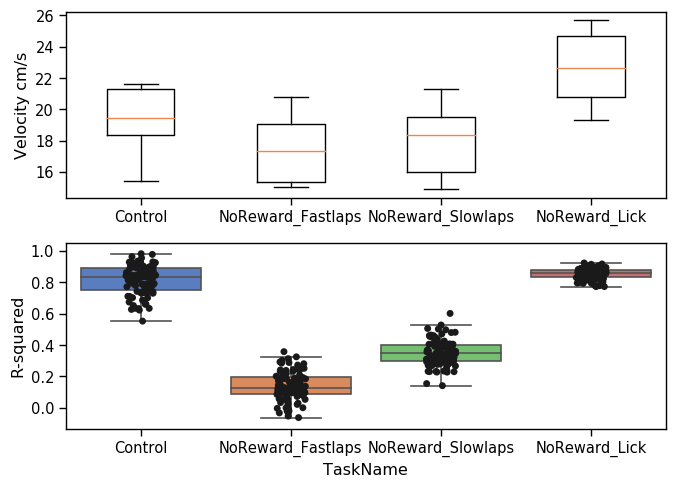

In [29]:
fs, ax1 = plt.subplots(2, 1, figsize=(7, 5), dpi=100)

# plot velocity distributions to show equality
ax1[0].boxplot([tracklength/lapvelocityA, tracklength/lapvelocityB,
                tracklength/correctedlaptime_worstlaps, tracklength/laptime_lick], showfliers=False)
ax1[0].set_xticklabels(['Control', 'NoReward_Fastlaps', 'NoReward_Slowlaps', 'NoReward_Lick'])
ax1[0].set_ylabel('Velocity cm/s')

sns.boxplot(x='TaskName', y='R2', data=R2, ax=ax1[1], showfliers=False)
sns.stripplot(x='TaskName', y='R2', data=R2, jitter=True, color='k', ax=ax1[1])
ax1[1].set_ylabel('R-squared');
fs.tight_layout()

### Save results

In [30]:
#Save R-squared dataframe
R2.to_pickle(os.path.join(SaveResults, 'velocity_comparison_shuffle_R2.pkl'))